# NBA MVP Prediction - Machine Learning

In diesem Projekt wird mithilfe von Machine Learning vorhergesagt, welche Spieler die besten Chancen auf den MVP-Titel in der NBA haben.  
Das Projekt kombiniert Daten aus mehreren Quellen, führt Feature Engineering durch, vergleicht verschiedene Modelle und deployed das beste Modell online.

## Datenimport & Datenquellen

- Spielerstatistiken (PPG, RPG, APG)
- Team-Winrates


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import joblib


In [26]:
df = pd.read_csv("nba_mvp_2004_2024_cleaned.csv")
df.head()


,Player,Team,Season,PPG,RPG,APG,Winrate,MVP
0,Allen Iverson,PHI,04_05,30.7,4.0,7.9,0.524,0
1,Kobe Bryant,LAL,04_05,27.6,5.9,6.0,0.415,0
2,LeBron James,CLE,04_05,27.2,7.4,7.2,0.512,0
3,Dirk Nowitzki,DAL,04_05,26.1,9.7,3.1,0.707,0
4,Amar'e Stoudemire,PHO,04_05,26.0,8.9,1.6,0.756,0


## Datenbereinigung & Feature Engineering

In diesem Schritt werden aus den vorhandenen Spieler- und Teamdaten sinnvolle Merkmale abgeleitet, 
die typische Eigenschaften eines MVP-Kandidaten widerspiegeln.

### Erzeugte Merkmale:

- **Top_Team**  
  → Binärmerkmal: 1, wenn das Team des Spielers eine Winrate von ≥ 60 % hatte.  
  MVPs kommen fast ausschließlich aus erfolgreichen Teams.

- **High_Scorer**  
  → 1, wenn der Spieler ≥ 25 Punkte pro Spiel erzielt hat.  
  MVPs gehören häufig zu den Top-Scorern der Liga.

- **Playmaker**  
  → 1, wenn der Spieler ≥ 5 Assists pro Spiel liefert.  
  Viele MVPs übernehmen neben dem Scoring auch eine Spielmacherrolle.

- **Rebounder**  
  → 1, wenn der Spieler ≥ 8 Rebounds pro Spiel holt.  
  Besonders für Big Men ist dies ein zentrales Leistungsmerkmal.

Diese Features erhöhen die Erklärbarkeit des Modells, da sie direkt Basketball-Wissen in strukturierte Form bringen.

In [37]:
# 1. Feature Engineering
df_feat = df_all.copy()

df_feat["Top_Team"] = df_feat["Winrate"].apply(lambda x: 1 if x >= 0.6 else 0)
df_feat["High_Scorer"] = df_feat["PPG"].apply(lambda x: 1 if x >= 25 else 0)
df_feat["Playmaker"] = df_feat["APG"].apply(lambda x: 1 if x >= 5 else 0)
df_feat["Rebounder"] = df_feat["RPG"].apply(lambda x: 1 if x >= 8 else 0)

df_feat["Weighted_Impact"] = (
    df_feat["PPG"] * 0.5 + df_feat["APG"] * 0.3 + df_feat["RPG"] * 0.2
) * df_feat["Winrate"]

df_feat["Scoring_Playmaking"] = df_feat["PPG"] + df_feat["APG"]
df_feat["PPG_per_Win"] = df_feat["PPG"] * df_feat["Winrate"]

# 2. Jetzt: Features + Ziel definieren
features = [
    "PPG", "APG", "RPG", "Winrate",
    "Top_Team", "High_Scorer", "Playmaker", "Rebounder",
    "Weighted_Impact", "Scoring_Playmaking", "PPG_per_Win"
]

# 3. Jetzt: dropna auf existierende Spalten
df_feat = df_feat.dropna(subset=features + ["MVP"])

# 4. Jetzt: X und y definieren
X = df_feat[features]
y = df_feat["MVP"]


## Feature Selektion & Modellvorbereitung

In diesem Abschnitt:
- Auswahl relevanter Merkmale (X) für die Modellierung
- Definition der Zielvariable (y = MVP)
- Entfernen von Zeilen mit fehlenden Werten (NaNs)
- Standardisierung der Eingabewerte (StandardScaler)
- Aufteilung in Trainings- und Testdaten (80/20 Split)

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Feature-Auswahl
features = [
    "PPG", "APG", "RPG", "Winrate",
    "Top_Team", "High_Scorer", "Playmaker", "Rebounder",
    "Weighted_Impact", "Scoring_Playmaking", "PPG_per_Win"
]

X = df_feat[features]
y = df_feat["MVP"]

# Skalierung
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test-Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Trainingsdaten:", X_train.shape)
print("✅ Testdaten:", X_test.shape)
print("🔍 Verteilung Zielvariable im Testset:", y_test.value_counts(normalize=True))


✅ Trainingsdaten: (2900, 11)
✅ Testdaten: (725, 11)
🔍 Verteilung Zielvariable im Testset: MVP
0    0.994483
1    0.005517
Name: proportion, dtype: float64


## Modelltraining

In diesem Abschnitt:
- Training von drei verschiedenen Modellen
- Klassifikation & Evaluation der Vorhersagen
- Vergleich der Modellgüte

### Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# 🎲 Random Forest
rf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# ➗ Logistic Regression
lr = LogisticRegression(class_weight="balanced", max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 📉 Lineare Regression (klassifiziert mit Threshold 0.5)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg_raw = linreg.predict(X_test)
y_pred_linreg = (y_pred_linreg_raw >= 0.5).astype(int)


## Evaluation

In [44]:
print("🎲 Random Forest\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

print("\n➗ Logistic Regression\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

print("\n📉 Lineare Regression (klassifiziert)\n", classification_report(y_test, y_pred_linreg))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_linreg))


🎲 Random Forest
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       721
           1       1.00      0.25      0.40         4

    accuracy                           1.00       725
   macro avg       1.00      0.62      0.70       725
weighted avg       1.00      1.00      0.99       725

Confusion Matrix:
 [[721   0]
 [  3   1]]

➗ Logistic Regression
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       721
           1       0.29      1.00      0.44         4

    accuracy                           0.99       725
   macro avg       0.64      0.99      0.72       725
weighted avg       1.00      0.99      0.99       725

Confusion Matrix:
 [[711  10]
 [  0   4]]

📉 Lineare Regression (klassifiziert)
               precision    recall  f1-score   support

           0       0.99      1.00      1.00       721
           1       0.00      0.00      0.00         4

    accuracy      

/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [41]:
# Cross-Validation – Random Forest
cv_rf = cross_val_score(
    RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    X_train, y_train, cv=5, scoring="f1"
)
print("\n🔁 Random Forest CV (F1):", cv_rf)
print("⌀ Durchschnittlicher F1:", cv_rf.mean())

# Cross-Validation – Logistic Regression
cv_lr = cross_val_score(
    LogisticRegression(class_weight="balanced", max_iter=1000),
    X_train, y_train, cv=5, scoring="f1"
)
print("\n🔁 Logistic Regression CV (F1):", cv_lr)
print("⌀ Durchschnittlicher F1:", cv_lr.mean())



🔁 Random Forest CV (F1): [0.4        0.         0.85714286 0.         0.85714286]
⌀ Durchschnittlicher F1: 0.4228571428571429

🔁 Logistic Regression CV (F1): [0.22222222 0.4        0.3        0.23529412 0.42105263]
⌀ Durchschnittlicher F1: 0.3157137942896457


# Modellvergleich

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, r2_score

# Random Forest
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf)
rf_rec = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

# Logistic Regression
lr_acc = accuracy_score(y_test, y_pred_lr)
lr_prec = precision_score(y_test, y_pred_lr)
lr_rec = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)

# Lineare Regression (klassifiziert)
linreg_acc = accuracy_score(y_test, y_pred_linreg_class)
linreg_prec = precision_score(y_test, y_pred_linreg_class)
linreg_rec = recall_score(y_test, y_pred_linreg_class)
linreg_f1 = f1_score(y_test, y_pred_linreg_class)
linreg_mse = mean_squared_error(y_test, y_pred_linreg)
linreg_r2 = r2_score(y_test, y_pred_linreg)

# Vergleichstabelle erstellen
import pandas as pd

data = {
    "Modell": ["Random Forest", "Logistic Regression", "Lineare Regression"],
    "Accuracy": [rf_acc, lr_acc, linreg_acc],
    "Precision (MVP=1)": [rf_prec, lr_prec, linreg_prec],
    "Recall (MVP=1)": [rf_rec, lr_rec, linreg_rec],
    "F1-Score (MVP=1)": [rf_f1, lr_f1, linreg_f1],
    "MSE": [None, None, linreg_mse],
    "R²": [None, None, linreg_r2]
}

vergleich_df = pd.DataFrame(data)
print(vergleich_df)


                Modell  Accuracy  Precision (MVP=1)  Recall (MVP=1)  \
0        Random Forest  0.949202           0.604167        0.644444   
1  Logistic Regression  0.888244           0.362069        0.933333   
2   Lineare Regression  0.939042           0.540541        0.444444   

   F1-Score (MVP=1)       MSE       R²  
0          0.623656       NaN      NaN  
1          0.521739       NaN      NaN  
2          0.487805  0.041703  0.31687  


## Modell speichern

In [8]:
joblib.dump(rf, "mvp_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [45]:
rf_final = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf_final.fit(X_scaled, y)

import joblib
joblib.dump(rf_final, "mvp_model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

## MVP Prediction 24/25

In [49]:
import pandas as pd

# CSV-Datei laden (z. B. teamranking_24_25.csv mit Semikolon-Trennung)
df_team = pd.read_csv("teamranking_24_25_cleaned.csv", sep=";")

# Nur relevante Spalten extrahieren
df_team_cleaned = df_team[["Team", "W/L%"]].copy()

# Umbenennen für Klarheit
df_team_cleaned.rename(columns={"W/L%": "Winrate"}, inplace=True)

# Season-Spalte hinzufügen
df_team_cleaned["Season"] = "24_25"

# Whitespace entfernen (optional)
df_team_cleaned["Team"] = df_team_cleaned["Team"].str.strip()

# Ergebnis anzeigen
print(df_team_cleaned.head())

# Optional: als neue Datei speichern
df_team_cleaned.to_csv("teamranking_24_25.csv", index=False)


  Team  Winrate Season
0  OKC    0.829  24_25
1  CLE    0.780  24_25
2  BOS    0.744  24_25
3  HOU    0.634  24_25
4  NYK    0.622  24_25


In [59]:
import pandas as pd

# 1. Spielerstatistiken laden
df_ppg = pd.read_csv("ppg_24_25_cleaned.csv", sep=";")

# 2. Relevante Spalten in numerisch umwandeln
df_ppg["G"] = pd.to_numeric(df_ppg["G"], errors="coerce")
df_ppg["TRB"] = pd.to_numeric(df_ppg["TRB"], errors="coerce")
df_ppg["AST"] = pd.to_numeric(df_ppg["AST"], errors="coerce")
df_ppg["PTS/G"] = pd.to_numeric(df_ppg["PTS/G"], errors="coerce")

# 3. Neue Spalten berechnen
df_ppg["PPG"] = df_ppg["PTS/G"]
df_ppg["APG"] = df_ppg["AST"] / df_ppg["G"]
df_ppg["RPG"] = df_ppg["TRB"] / df_ppg["G"]

# 4. Team & Season formatieren
df_ppg["Team"] = df_ppg["Team"].astype(str).str.extract(r"([A-Z]{3})")
df_ppg["Season"] = "24_25"

# 5. Teamranking laden
df_team = pd.read_csv("teamranking_24_25.csv")

# 6. Merge nach Team und Season
df_merged = pd.merge(df_ppg, df_team, on=["Team", "Season"], how="left")

# 7. Nur die benötigten Spalten behalten
df_final = df_merged[["Player", "Team", "Season", "PPG", "APG", "RPG", "Winrate"]]

# 8. Optional speichern
df_final.to_csv("nba_24_25_ready.csv", index=False)

# 9. Vorschau
print(df_final.head())


                    Player Team Season   PPG        APG        RPG  Winrate
0  Shai Gilgeous-Alexander  OKC  24_25  32.7   6.394737   4.986842    0.829
1    Giannis Antetokounmpo  MIL  24_25  30.4   6.462687  11.910448    0.585
2             Nikola Jokić  DEN  24_25  29.6  10.228571  12.742857    0.610
3              Luka Dončić  DAL  24_25  28.2   7.660000   8.180000    0.476
4          Anthony Edwards  MIN  24_25  27.6   4.544304   5.696203    0.598


In [56]:
import pandas as pd

# 🔹 1. Spielerstatistiken laden
df_ppg = pd.read_csv("ppg_24_25.csv")  # enthält: Player, Team, Season, PPG

# 🔧 2. Team-Spalte bereinigen → nur erstes gültiges Kürzel (z. B. 'DAL' aus 'DALLAL')
df_ppg["Team"] = df_ppg["Team"].str.extract(r"([A-Z]{3})")  # nimmt das erste 3-Buchstaben-Kürzel

# 🔹 3. Team-Winrate laden
df_team = pd.read_csv("teamranking_24_25.csv")  # enthält: Team, Winrate, Season

# 🔗 4. Merge nach Team & Season
df_merged = pd.merge(df_ppg, df_team, on=["Team", "Season"], how="left")

# 🔍 5. Prüfung auf fehlende Winrates
missing = df_merged[df_merged["Winrate"].isna()]
if not missing.empty:
    print("⚠️ Warnung: Winrate fehlt für folgende Teams:")
    print(missing["Team"].unique())
else:
    print("✅ Alle Teams erfolgreich gemerged.")

# 💾 6. Optional speichern
df_merged.to_csv("merged_ppg_team_24_25.csv", index=False)

# 📊 Vorschau
print(df_merged.head())


✅ Alle Teams erfolgreich gemerged.
                    Player Team Season   PPG  Winrate
0  Shai Gilgeous-Alexander  OKC  24_25  32.7    0.829
1    Giannis Antetokounmpo  MIL  24_25  30.4    0.585
2             Nikola Jokić  DEN  24_25  29.6    0.610
3              Luka Dončić  DAL  24_25  28.2    0.476
4          Anthony Edwards  MIN  24_25  27.6    0.598


# Daten vorbereiten

In [1]:
import pandas as pd

df_mvp = pd.read_csv("mvp_04_05_clean.csv")
df_mvp = df_mvp[["Player", "Season", "MVP"]]
df_mvp["Player"] = df_mvp["Player"].str.strip()
df_mvp["Season"] = df_mvp["Season"].str.strip()

df_ppg = pd.read_csv("ppg_04_05_cleaned.csv")
df_ppg["Player"] = df_ppg["Player"].str.strip()
df_ppg["Team"] = df_ppg["Team"].str.strip()
df_ppg["Season"] = df_ppg["Season"].str.strip()

df_team = pd.read_csv("teamranking_04_05_cleaned.csv")
df_team["Team"] = df_team["Team"].str.strip()
df_team["Season"] = df_team["Season"].str.strip()

# Merge PPG + Team Winrate
df = pd.merge(df, df_mvp, on=["Player", "Season"], how="left")
df["MVP"] = df["MVP"].fillna(0).astype(int)  # fallback falls MVP-Wert fehlt


print(df[df["MVP"] == 1])



FileNotFoundError: [Errno 2] No such file or directory: 'mvp_04_05_clean.csv'

In [ ]:
import pandas as pd
from unidecode import unidecode
import os

# Ziel-Datenstruktur
all_data = []

# Alle Seasons definieren
seasons = [f"{str(y)[-2:]}_{str(y+1)[-2:]}" for y in range(2004, 2024)]

for season in seasons:
    try:
        print(f"📊 Verarbeite Saison {season}...")

        # ---- Dateien laden ----
        df_ppg = pd.read_csv(f"ppg_{season}_cleaned.csv")
        df_team = pd.read_csv(f"teamranking_{season}_cleaned.csv")
        df_mvp = pd.read_csv(f"mvp_{season}_clean.csv")

        # 🔧 Falls "Season" fehlt im MVP-Datensatz → hinzufügen (vor Bearbeitung!)
        if "Season" not in df_mvp.columns:
            df_mvp["Season"] = season

        # ---- Vorverarbeitung: Unicode & Whitespace entfernen ----
        for df in [df_ppg, df_team, df_mvp]:
            for col in ["Player", "Team", "Season"]:
                if col in df.columns:
                    df[col] = df[col].astype(str).str.strip().apply(unidecode)

        # Nur MVP = 1 behalten
        df_mvp = df_mvp[df_mvp["MVP"] == 1][["Player", "Season", "MVP"]]

        # ---- Merge aller Daten ----
        df = pd.merge(df_ppg, df_team, on=["Team", "Season"], how="left")
        df = pd.merge(df, df_mvp, on=["Player", "Season"], how="left")
        df["MVP"] = df["MVP"].fillna(0).astype(int)

        all_data.append(df)

    except Exception as e:
        print(f"⚠️ Fehler bei Saison {season}: {e}")

# 🔁 Alle verarbeiteten Saisons kombinieren
df_all = pd.concat(all_data, ignore_index=True)

print(f"\n✅ Gesamt-Datensatz: {df_all.shape[0]} Zeilen, {df_all['MVP'].sum()} MVPs erkannt.")

# 💾 Optional speichern
df_all.to_csv("nba_mvp_2004_2024_cleaned.csv", index=False)


📊 Verarbeite Saison 04_05...
📊 Verarbeite Saison 05_06...
📊 Verarbeite Saison 06_07...
📊 Verarbeite Saison 07_08...
📊 Verarbeite Saison 08_09...
📊 Verarbeite Saison 09_10...
📊 Verarbeite Saison 10_11...
📊 Verarbeite Saison 11_12...
📊 Verarbeite Saison 12_13...
📊 Verarbeite Saison 13_14...
📊 Verarbeite Saison 14_15...
📊 Verarbeite Saison 15_16...
📊 Verarbeite Saison 16_17...
📊 Verarbeite Saison 17_18...
📊 Verarbeite Saison 18_19...
📊 Verarbeite Saison 19_20...
📊 Verarbeite Saison 20_21...
📊 Verarbeite Saison 21_22...
📊 Verarbeite Saison 22_23...
📊 Verarbeite Saison 23_24...

✅ Gesamt-Datensatz: 4000 Zeilen, 20 MVPs erkannt.


### 24/25

In [ ]:
import pandas as pd
import os

# Ordner
input_dir = "Archiv"
output_dir = "Final_Merged"
os.makedirs(output_dir, exist_ok=True)

# Saisonliste (2004/05 – 2023/24)
seasons = [f"{str(y).zfill(2)}_{str(y+1).zfill(2)}" for y in range(4, 24)]

for season in seasons:
    try:
        print(f"🔄 Verarbeite Saison: {season}")

        # -------------------------------
        # 1. Spielerstatistiken (PPG, RPG, APG)
        # -------------------------------
        ppg_path = f"{input_dir}/ppg_{season}_cleaned.csv"
        ppg_df = pd.read_csv(ppg_path)
        ppg_df["Player"] = ppg_df["Player"].astype(str).str.strip()
        ppg_df["Team"] = ppg_df["Team"].astype(str).str.strip()
        ppg_df["Season"] = season

        # -------------------------------
        # 2. Team-Winrate
        # -------------------------------
        team_path = f"{input_dir}/teamranking_{season}_cleaned.csv"
        team_df = pd.read_csv(team_path)
        team_df["Team"] = team_df["Team"].astype(str).str.strip()
        team_df["Season"] = team_df["Season"].astype(str)

        # Merge PPG + Team-Winrate
        merged = pd.merge(ppg_df, team_df[["Team", "Season", "Winrate"]], on=["Team", "Season"], how="left")

        # -------------------------------
        # 3. MVP-Daten
        # -------------------------------
        mvp_path = f"{input_dir}/mvp_{season}_clean.csv"
        mvp_df = pd.read_csv(mvp_path)

        # Robust: Nur Player & Season & MVP, ignoriert -9999 oder andere störende Spalten
        mvp_df["Player"] = mvp_df["Player"].astype(str).str.strip()
        mvp_df["Season"] = season
        mvp_df["MVP"] = 1  # alle in dieser Datei sind MVPs
        mvp_df = mvp_df[["Player", "Season", "MVP"]]

        # Merge MVP
        merged = pd.merge(merged, mvp_df, on=["Player", "Season"], how="left")
        merged["MVP"] = merged["MVP"].fillna(0).astype(int)

        # -------------------------------
        # 4. Speichern
        # -------------------------------
        output_path = f"{output_dir}/nba_{season}_merged.csv"
        merged.to_csv(output_path, index=False)
        print(f"✅ Gespeichert: {output_path}")

    except Exception as e:
        print(f"❌ Fehler bei Saison {season}: {e}")


🔄 Verarbeite Saison: 04_05
✅ Gespeichert: Final_Merged/nba_04_05_merged.csv
🔄 Verarbeite Saison: 05_06
✅ Gespeichert: Final_Merged/nba_05_06_merged.csv
🔄 Verarbeite Saison: 06_07
✅ Gespeichert: Final_Merged/nba_06_07_merged.csv
🔄 Verarbeite Saison: 07_08
✅ Gespeichert: Final_Merged/nba_07_08_merged.csv
🔄 Verarbeite Saison: 08_09
✅ Gespeichert: Final_Merged/nba_08_09_merged.csv
🔄 Verarbeite Saison: 09_10
✅ Gespeichert: Final_Merged/nba_09_10_merged.csv
🔄 Verarbeite Saison: 10_11
✅ Gespeichert: Final_Merged/nba_10_11_merged.csv
🔄 Verarbeite Saison: 11_12
✅ Gespeichert: Final_Merged/nba_11_12_merged.csv
🔄 Verarbeite Saison: 12_13
✅ Gespeichert: Final_Merged/nba_12_13_merged.csv
🔄 Verarbeite Saison: 13_14
✅ Gespeichert: Final_Merged/nba_13_14_merged.csv
🔄 Verarbeite Saison: 14_15
✅ Gespeichert: Final_Merged/nba_14_15_merged.csv
🔄 Verarbeite Saison: 15_16
✅ Gespeichert: Final_Merged/nba_15_16_merged.csv
🔄 Verarbeite Saison: 16_17
✅ Gespeichert: Final_Merged/nba_16_17_merged.csv
🔄 Verarbeite

In [ ]:
import pandas as pd
import os

# Ordner, in dem deine CSVs liegen
input_dir = "Archiv"
output_dir = "Archiv_cleaned"
os.makedirs(output_dir, exist_ok=True)

# Liste der Saisons: 04_05 bis 23_24
seasons = [f"{str(y).zfill(2)}_{str(y+1).zfill(2)}" for y in range(4, 24)]

for season in seasons:
    try:
        print(f"🔄 Verarbeite ppg_{season}.csv")

        # Datei einlesen
        df = pd.read_csv(f"{input_dir}/ppg_{season}.csv", sep=";")

        # Nur Spieler mit Einsätzen
        df = df[df["G"] > 0]

        # Umbenennen für Konsistenz
        df = df.rename(columns={
            "PTS/G": "PPG",
            "TRB": "TRB_total",
            "AST": "AST_total"
        })

        # Neue per-game Features berechnen
        df["RPG"] = df["TRB_total"] / df["G"]
        df["APG"] = df["AST_total"] / df["G"]

        # Rundung auf 1 Nachkommastelle
        df["RPG"] = df["RPG"].round(1)
        df["APG"] = df["APG"].round(1)

        # Strings bereinigen
        df["Player"] = df["Player"].astype(str).str.strip()
        df["Team"] = df["Team"].astype(str).str.strip()
        df["Season"] = season

        # Relevante Spalten auswählen
        df_cleaned = df[["Player", "Team", "Season", "PPG", "RPG", "APG"]]

        # Speichern
        df_cleaned.to_csv(f"{output_dir}/ppg_{season}_cleaned.csv", index=False)
        print(f"✅ Gespeichert: ppg_{season}_cleaned.csv")

    except Exception as e:
        print(f"❌ Fehler bei ppg_{season}: {e}")


🔄 Verarbeite ppg_04_05.csv
✅ Gespeichert: ppg_04_05_cleaned.csv
🔄 Verarbeite ppg_05_06.csv
✅ Gespeichert: ppg_05_06_cleaned.csv
🔄 Verarbeite ppg_06_07.csv
✅ Gespeichert: ppg_06_07_cleaned.csv
🔄 Verarbeite ppg_07_08.csv
✅ Gespeichert: ppg_07_08_cleaned.csv
🔄 Verarbeite ppg_08_09.csv
✅ Gespeichert: ppg_08_09_cleaned.csv
🔄 Verarbeite ppg_09_10.csv
✅ Gespeichert: ppg_09_10_cleaned.csv
🔄 Verarbeite ppg_10_11.csv
✅ Gespeichert: ppg_10_11_cleaned.csv
🔄 Verarbeite ppg_11_12.csv
✅ Gespeichert: ppg_11_12_cleaned.csv
🔄 Verarbeite ppg_12_13.csv
✅ Gespeichert: ppg_12_13_cleaned.csv
🔄 Verarbeite ppg_13_14.csv
✅ Gespeichert: ppg_13_14_cleaned.csv
🔄 Verarbeite ppg_14_15.csv
✅ Gespeichert: ppg_14_15_cleaned.csv
🔄 Verarbeite ppg_15_16.csv
✅ Gespeichert: ppg_15_16_cleaned.csv
🔄 Verarbeite ppg_16_17.csv
✅ Gespeichert: ppg_16_17_cleaned.csv
🔄 Verarbeite ppg_17_18.csv
✅ Gespeichert: ppg_17_18_cleaned.csv
🔄 Verarbeite ppg_18_19.csv
✅ Gespeichert: ppg_18_19_cleaned.csv
🔄 Verarbeite ppg_19_20.csv
✅ Gespeichert

### 23/24

In [ ]:
import pandas as pd

df = pd.read_csv("MVP_23-24.csv", sep=';')

# Erste Zeile als Spaltennamen verwenden
df.columns = df.iloc[0]             # Erste Zeile = Spaltennamen
df_clean = df[1:].reset_index(drop=True)  # nur ab Zeile 1, nicht Zeile 2
df_clean = df_clean[df_clean['Player'].notna()]  # Leere raus

# Spalten umbenennen
df_clean = df_clean.rename(columns={
    'Player': 'Player',
    'PTS': 'PPG',
    'TRB': 'RPG',
    'AST': 'APG',
    'Tm': 'Team',
    'Rank': 'Rank'
})


# MVP-Label erstellen
df_clean["MVP"] = df_clean["Rank"].apply(lambda x: 1 if str(x).strip() == "1" else 0)

# Datentypen konvertieren
df_clean["PPG"] = df_clean["PPG"].astype(float)
df_clean["RPG"] = df_clean["RPG"].astype(float)
df_clean["APG"] = df_clean["APG"].astype(float)

# Vorschau
print(df_clean[["Player", "Team", "PPG", "RPG", "APG", "MVP"]])


FileNotFoundError: [Errno 2] No such file or directory: 'MVP_23-24.csv'

In [ ]:
df_clean.to_csv("mvp_23_24_clean.csv", index=False)

In [ ]:
ppg_df = pd.read_csv("PlayerStats_RankedByPPG_23-24.csv", sep=";", encoding="ISO-8859-1")

ppg_df = ppg_df.rename(columns={
    "Player": "Player",
    "Team": "Team",
    "PTS/G": "PPG",
    "TRB": "RPG",
    "AST": "APG"
})

ppg_df = ppg_df[["Player", "Team", "PPG", "RPG", "APG"]]
ppg_df["PPG"] = ppg_df["PPG"].astype(float)
ppg_df["RPG"] = ppg_df["RPG"].astype(float)
ppg_df["APG"] = ppg_df["APG"].astype(float)

ppg_df["Player"] = ppg_df["Player"].str.encode("latin1").str.decode("utf-8", errors="ignore")
ppg_df["Player"] = ppg_df["Player"].str.strip()

print(ppg_df.head())



                    Player Team   PPG    RPG    APG
0              Joel Embiid  PHI  34.7  430.0  219.0
1              Luka Dončić  DAL  33.9  647.0  686.0
2    Giannis Antetokounmpo  MIL  30.4  841.0  476.0
3  Shai Gilgeous-Alexander  OKC  30.1  415.0  465.0
4            Jalen Brunson  NYK  28.7  278.0  519.0


In [ ]:
ppg_df.to_csv("ppg_23_24_cleaned.csv", index=False)

In [ ]:
import pandas as pd

# 1. CSV einlesen
team_df = pd.read_csv("TeamRanking_23-24.csv", sep=";", encoding="ISO-8859-1")

# 2. Spaltennamen säubern (BOM entfernen, 'W/L%' → 'Winrate')
team_df = team_df.rename(columns={
    "ï»¿Rk": "Rank",
    "W/L%": "Winrate"
})

# 3. Nur die relevanten Spalten behalten
team_clean = team_df[["Team", "Winrate"]].copy()

# 4. Whitespace entfernen
team_clean["Team"] = team_clean["Team"].str.strip()

# 5. Winrate als float casten (falls Komma statt Punkt verwendet wurde)
team_clean["Winrate"] = pd.to_numeric(team_clean["Winrate"], errors="coerce")

# 6. Nullwerte & Duplikate entfernen
team_clean = team_clean.dropna(subset=["Team", "Winrate"])
team_clean = team_clean.drop_duplicates(subset="Team")

# 7. Ergebnis anzeigen
print(team_clean.head())

# Optional: Speichern
team_clean.to_csv("TeamRanking_23-24_cleaned.csv", index=False)


  Team  Winrate
0  BOS    0.780
1  OKC    0.695
2  DEN    0.695
3  MIN    0.683
4  LAC    0.622


DATEN MERGEN

In [ ]:
import pandas as pd

# -------------------------------
# 1. Spielerstatistiken (PPG, RPG, APG)
# -------------------------------
ppg_df = pd.read_csv("ppg_23_24.csv")  # Beispielname
ppg_df["Player"] = ppg_df["Player"].str.strip()
ppg_df["Team"] = ppg_df["Team"].str.strip()
ppg_df["PPG"] = pd.to_numeric(ppg_df["PPG"], errors="coerce")
ppg_df["RPG"] = pd.to_numeric(ppg_df["RPG"], errors="coerce")
ppg_df["APG"] = pd.to_numeric(ppg_df["APG"], errors="coerce")

# -------------------------------
# 2. MVP-Daten
# -------------------------------
mvp_df = pd.read_csv("mvp_23_24.csv")  # Beispielname
mvp_df["Player"] = mvp_df["Player"].str.strip()
mvp_df["Team"] = mvp_df["Team"].str.strip()
mvp_df["MVP"] = pd.to_numeric(mvp_df["MVP"], errors="coerce")
mvp_df = mvp_df[["Player", "MVP"]]  # nur relevante Spalten

# -------------------------------
# 3. Team-Winrate
# -------------------------------
team_df = pd.read_csv("TeamRanking_23-24.csv")  # Beispielname
team_df["Team"] = team_df["Team"].str.strip()
team_df["Winrate"] = pd.to_numeric(team_df["Winrate"], errors="coerce")

# -------------------------------
# 4. Merge: PPG + MVP
# -------------------------------
merged_df = pd.merge(ppg_df, mvp_df, on="Player", how="left")
merged_df["MVP"] = merged_df["MVP"].fillna(0).astype(int)

# -------------------------------
# 5. Merge: + Team-Winrate
# -------------------------------
final_df = pd.merge(merged_df, team_df, on="Team", how="left")

# -------------------------------
# 6. Ausgabe
# -------------------------------
print(final_df.head())
final_df.to_csv("nba_2023_24_merged.csv", index=False)


                    Player Team   PPG    RPG    APG  MVP  Winrate
0              Joel Embiid  PHI  34.7  430.0  219.0    0    0.573
1              Luka Dončić  DAL  33.9  647.0  686.0    0    0.610
2    Giannis Antetokounmpo  MIL  30.4  841.0  476.0    0    0.598
3  Shai Gilgeous-Alexander  OKC  30.1  415.0  465.0    0    0.695
4            Jalen Brunson  NYK  28.7  278.0  519.0    0    0.610


### 22/23

In [ ]:
import pandas as pd

df = pd.read_csv("mvp_22_23.csv", sep=';')

# Erste Zeile als Spaltennamen verwenden
df.columns = df.iloc[0]             # Erste Zeile = Spaltennamen
df_clean = df[1:].reset_index(drop=True)  # nur ab Zeile 1, nicht Zeile 2
df_clean = df_clean[df_clean['Player'].notna()]  # Leere raus

# Spalten umbenennen
df_clean = df_clean.rename(columns={
    'Player': 'Player',
    'PTS': 'PPG',
    'TRB': 'RPG',
    'AST': 'APG',
    'Tm': 'Team',
    'Rank': 'Rank'
})


# MVP-Label erstellen
df_clean["MVP"] = df_clean["Rank"].apply(lambda x: 1 if str(x).strip() == "1" else 0)

# Datentypen konvertieren
df_clean["PPG"] = df_clean["PPG"].astype(float)
df_clean["RPG"] = df_clean["RPG"].astype(float)
df_clean["APG"] = df_clean["APG"].astype(float)

# Vorschau
print(df_clean[["Player", "Team", "PPG", "RPG", "APG", "MVP"]])

df_clean.to_csv("mvp_22_23_clean.csv", index=False)

0                    Player Team   PPG   RPG  APG  MVP
0               Joel Embiid  PHI  33.1  10.2  4.2    1
1              Nikola Jokić  DEN  24.5  11.8  9.8    0
2     Giannis Antetokounmpo  MIL  31.1  11.8  5.7    0
3              Jayson Tatum  BOS  30.1   8.8  4.6    0
4   Shai Gilgeous-Alexander  OKC  31.4   4.8  5.5    0
5          Donovan Mitchell  CLE  28.3   4.3  4.4    0
6          Domantas Sabonis  SAC  19.1  12.3  7.3    0
7               Luka Dončić  DAL  32.4   8.6  8.0    0
8             Stephen Curry  GSW  29.4   6.1  6.3    0
9              Jimmy Butler  MIA  22.9   5.9  5.3    0
10             De'Aaron Fox  SAC  25.0   4.2  6.1    0


In [ ]:
import pandas as pd

# 1. CSV einlesen
team_df = pd.read_csv("teamRanking_22-23.csv", sep=";", encoding="ISO-8859-1")

# 2. Spaltennamen säubern (BOM entfernen, 'W/L%' → 'Winrate')
team_df = team_df.rename(columns={
    "Rk": "Rank",
    "W/L%": "Winrate"
})

# 3. Nur die relevanten Spalten behalten
team_clean = team_df[["Team", "Winrate"]].copy()

# 4. Whitespace entfernen
team_clean["Team"] = team_clean["Team"].str.strip()

# 5. Winrate als float casten (falls Komma statt Punkt verwendet wurde)
team_clean["Winrate"] = pd.to_numeric(team_clean["Winrate"], errors="coerce")

# 6. Nullwerte & Duplikate entfernen
team_clean = team_clean.dropna(subset=["Team", "Winrate"])
team_clean = team_clean.drop_duplicates(subset="Team")

# 7. Ergebnis anzeigen
print(team_clean.head())

# Optional: Speichern
team_clean.to_csv("TeamRanking_22-23_cleaned.csv", index=False)


  Team  Winrate
0  MIL    0.707
1  BOS    0.695
2  PHI    0.659
3  DEN    0.646
4  CLE    0.622


In [ ]:
ppg_df = pd.read_csv("PlayerStats_RankedByPPG_22-23.csv", sep=";", encoding="ISO-8859-1")

ppg_df = ppg_df.rename(columns={
    "Player": "Player",
    "Team": "Team",
    "PTS/G": "PPG",
    "TRB": "RPG",
    "AST": "APG"
})

ppg_df = ppg_df[["Player", "Team", "PPG", "RPG", "APG"]]
ppg_df["PPG"] = ppg_df["PPG"].astype(float)
ppg_df["RPG"] = ppg_df["RPG"].astype(float)
ppg_df["APG"] = ppg_df["APG"].astype(float)

ppg_df["Player"] = ppg_df["Player"].str.encode("latin1").str.decode("utf-8", errors="ignore")
ppg_df["Player"] = ppg_df["Player"].str.strip()

print(ppg_df.head())

ppg_df.to_csv("ppg_22_23_cleaned.csv", index=False)

                    Player Team   PPG    RPG    APG
0              Joel Embiid  PHI  33.1  670.0  274.0
1              Luka Dončić  DAL  32.4  569.0  529.0
2           Damian Lillard  POR  32.2  277.0  425.0
3  Shai Gilgeous-Alexander  OKC  31.4  329.0  371.0
4    Giannis Antetokounmpo  MIL  31.1  742.0  359.0


In [ ]:
import pandas as pd

# -------------------------------
# 1. Spielerstatistiken (PPG, RPG, APG)
# -------------------------------
ppg_df = pd.read_csv("ppg_22_23_cleaned.csv")  # Beispielname
ppg_df["Player"] = ppg_df["Player"].str.strip()
ppg_df["Team"] = ppg_df["Team"].str.strip()
ppg_df["PPG"] = pd.to_numeric(ppg_df["PPG"], errors="coerce")
ppg_df["RPG"] = pd.to_numeric(ppg_df["RPG"], errors="coerce")
ppg_df["APG"] = pd.to_numeric(ppg_df["APG"], errors="coerce")

# -------------------------------
# 2. MVP-Daten
# -------------------------------
mvp_df = pd.read_csv("mvp_22_23_clean.csv")  # Beispielname
mvp_df["Player"] = mvp_df["Player"].str.strip()
mvp_df["Team"] = mvp_df["Team"].str.strip()
mvp_df["MVP"] = pd.to_numeric(mvp_df["MVP"], errors="coerce")
mvp_df = mvp_df[["Player", "MVP"]]  # nur relevante Spalten

# -------------------------------
# 3. Team-Winrate
# -------------------------------
team_df = pd.read_csv("TeamRanking_22-23_cleaned.csv")  # Beispielname
team_df["Team"] = team_df["Team"].str.strip()
team_df["Winrate"] = pd.to_numeric(team_df["Winrate"], errors="coerce")

# -------------------------------
# 4. Merge: PPG + MVP
# -------------------------------
merged_df = pd.merge(ppg_df, mvp_df, on="Player", how="left")
merged_df["MVP"] = merged_df["MVP"].fillna(0).astype(int)

# -------------------------------
# 5. Merge: + Team-Winrate
# -------------------------------
final_df = pd.merge(merged_df, team_df, on="Team", how="left")

# -------------------------------
# 6. Ausgabe
# -------------------------------
print(final_df.head())
final_df.to_csv("nba_2022_23_merged.csv", index=False)


                    Player Team   PPG    RPG    APG  MVP  Winrate
0              Joel Embiid  PHI  33.1  670.0  274.0    1    0.659
1              Luka Dončić  DAL  32.4  569.0  529.0    0    0.463
2           Damian Lillard  POR  32.2  277.0  425.0    0    0.402
3  Shai Gilgeous-Alexander  OKC  31.4  329.0  371.0    0    0.488
4    Giannis Antetokounmpo  MIL  31.1  742.0  359.0    0    0.707


### 21/22

In [ ]:
import pandas as pd

df = pd.read_csv("mvp_21_22.csv", sep=';')

# Erste Zeile als Spaltennamen verwenden
df.columns = df.iloc[0]             # Erste Zeile = Spaltennamen
df_clean = df[1:].reset_index(drop=True)  # nur ab Zeile 1, nicht Zeile 2


# Spalten umbenennen
df_clean = df_clean.rename(columns={
    'Player': 'Player',
    'PTS': 'PPG',
    'TRB': 'RPG',
    'AST': 'APG',
    'Tm': 'Team',
    'Rank': 'Rank'
})


# MVP-Label erstellen
df_clean["MVP"] = df_clean["Rank"].apply(lambda x: 1 if str(x).strip() == "1" else 0)

# Datentypen konvertieren
df_clean["PPG"] = df_clean["PPG"].astype(float)
df_clean["RPG"] = df_clean["RPG"].astype(float)
df_clean["APG"] = df_clean["APG"].astype(float)

# Vorschau
print(df_clean[["Player", "Team", "PPG", "RPG", "APG", "MVP"]])

df_clean.to_csv("mvp_21_22_clean.csv", index=False)

0                 Player Team   PPG   RPG   APG  MVP
0           Nikola Jokić  DEN  27.1  13.8   7.9    1
1            Joel Embiid  PHI  30.6  11.7   4.2    0
2  Giannis Antetokounmpo  MIL  29.9  11.6   5.8    0
3           Devin Booker  PHO  26.8   5.0   4.8    0
4            Luka Dončić  DAL  28.4   9.1   8.7    0
5           Jayson Tatum  BOS  26.9   8.0   4.4    0
6              Ja Morant  MEM  27.4   5.7   6.7    0
7          Stephen Curry  GSW  25.5   5.2   6.3    0
8             Chris Paul  PHO  14.7   4.4  10.8    0


In [ ]:
ppg_df = pd.read_csv("ppg_21_22.csv", sep=";", encoding="ISO-8859-1")

ppg_df = ppg_df.rename(columns={
    "Player": "Player",
    "Team": "Team",
    "PTS/G": "PPG",
    "TRB": "RPG",
    "AST": "APG"
})

ppg_df = ppg_df[["Player", "Team", "PPG", "RPG", "APG"]]
ppg_df["PPG"] = ppg_df["PPG"].astype(float)
ppg_df["RPG"] = ppg_df["RPG"].astype(float)
ppg_df["APG"] = ppg_df["APG"].astype(float)

ppg_df["Player"] = ppg_df["Player"].str.encode("latin1").str.decode("utf-8", errors="ignore")
ppg_df["Player"] = ppg_df["Player"].str.strip()

print(ppg_df.head())

ppg_df.to_csv("ppg_21_22_cleaned.csv", index=False)

                  Player Team   PPG    RPG    APG
0            Joel Embiid  PHI  30.6  796.0  284.0
1           LeBron James  LAL  30.3  459.0  349.0
2  Giannis Antetokounmpo  MIL  29.9  778.0  388.0
3           Kevin Durant  BRK  29.9  407.0  351.0
4            Luka Dončić  DAL  28.4  593.0  568.0


In [ ]:
import pandas as pd

# 1. CSV einlesen
team_df = pd.read_csv("teamranking_21_22.csv", sep=";", encoding="ISO-8859-1")

# 2. Spaltennamen säubern (BOM entfernen, 'W/L%' → 'Winrate')
team_df = team_df.rename(columns={
    "Rk": "Rank",
    "W/L%": "Winrate"
})

# 3. Nur die relevanten Spalten behalten
team_clean = team_df[["Team", "Winrate"]].copy()

# 4. Whitespace entfernen
team_clean["Team"] = team_clean["Team"].str.strip()

# 5. Winrate als float casten (falls Komma statt Punkt verwendet wurde)
team_clean["Winrate"] = pd.to_numeric(team_clean["Winrate"], errors="coerce")

# 6. Nullwerte & Duplikate entfernen
team_clean = team_clean.dropna(subset=["Team", "Winrate"])
team_clean = team_clean.drop_duplicates(subset="Team")

# 7. Ergebnis anzeigen
print(team_clean.head())

# Optional: Speichern
team_clean.to_csv("teamranking_21_22_cleaned.csv", index=False)


  Team  Winrate
0  PHO    0.780
1  MEM    0.683
2  MIA    0.646
3  GSW    0.646
4  DAL    0.634


In [ ]:
import pandas as pd

# -------------------------------
# 1. Spielerstatistiken (PPG, RPG, APG)
# -------------------------------
ppg_df = pd.read_csv("ppg_21_22_cleaned.csv")  # Beispielname
ppg_df["Player"] = ppg_df["Player"].str.strip()
ppg_df["Team"] = ppg_df["Team"].str.strip()
ppg_df["PPG"] = pd.to_numeric(ppg_df["PPG"], errors="coerce")
ppg_df["RPG"] = pd.to_numeric(ppg_df["RPG"], errors="coerce")
ppg_df["APG"] = pd.to_numeric(ppg_df["APG"], errors="coerce")

# -------------------------------
# 2. MVP-Daten
# -------------------------------
mvp_df = pd.read_csv("mvp_21_22_clean.csv")  # Beispielname
mvp_df["Player"] = mvp_df["Player"].str.strip()
mvp_df["Team"] = mvp_df["Team"].str.strip()
mvp_df["MVP"] = pd.to_numeric(mvp_df["MVP"], errors="coerce")
mvp_df = mvp_df[["Player", "MVP"]]  # nur relevante Spalten

# -------------------------------
# 3. Team-Winrate
# -------------------------------
team_df = pd.read_csv("teamranking_21_22_cleaned.csv")  # Beispielname
team_df["Team"] = team_df["Team"].str.strip()
team_df["Winrate"] = pd.to_numeric(team_df["Winrate"], errors="coerce")

# -------------------------------
# 4. Merge: PPG + MVP
# -------------------------------
merged_df = pd.merge(ppg_df, mvp_df, on="Player", how="left")
merged_df["MVP"] = merged_df["MVP"].fillna(0).astype(int)

# -------------------------------
# 5. Merge: + Team-Winrate
# -------------------------------
final_df = pd.merge(merged_df, team_df, on="Team", how="left")

# -------------------------------
# 6. Ausgabe
# -------------------------------
print(final_df.head())
final_df.to_csv("nba_2021_22.csv", index=False)


                  Player Team   PPG    RPG    APG  MVP  Winrate
0            Joel Embiid  PHI  30.6  796.0  284.0    0    0.622
1           LeBron James  LAL  30.3  459.0  349.0    0    0.402
2  Giannis Antetokounmpo  MIL  29.9  778.0  388.0    0    0.622
3           Kevin Durant  BRK  29.9  407.0  351.0    0    0.537
4            Luka Dončić  DAL  28.4  593.0  568.0    0    0.634


### 2004/05 - 20/21

In [ ]:
import pandas as pd
# 1. CSV einlesen
team_df = pd.read_csv("teamranking_20_21.csv", sep=";", encoding="ISO-8859-1")
# 2. Spaltennamen säubern (BOM entfernen, 'W/L%' → 'Winrate')
team_df = team_df.rename(columns={
    "Rk": "Rank",
    "W/L%": "Winrate"
})
# 3. Nur die relevanten Spalten behalten
team_clean = team_df[["Team", "Winrate"]].copy()
# 4. Whitespace entfernen
team_clean["Team"] = team_clean["Team"].str.strip()
# 5. Winrate als float casten (falls Komma statt Punkt verwendet wurde)
team_clean["Winrate"] = pd.to_numeric(team_clean["Winrate"], errors="coerce")
# 6. Nullwerte & Duplikate entfernen
team_clean = team_clean.dropna(subset=["Team", "Winrate"])
team_clean = team_clean.drop_duplicates(subset="Team")
# 7. Ergebnis anzeigen
print(team_clean.head())
# Optional: Speichern
team_clean.to_csv("teamranking_20_21_cleaned.csv", index=False)

  Team  Winrate
0  UTA    0.722
1  PHO    0.708
2  PHI    0.681
3  BRK    0.667
4  DEN    0.653


In [ ]:
import pandas as pd
df = pd.read_csv("mvp_20_21.csv", sep=';')
# Erste Zeile als Spaltennamen verwenden
df.columns = df.iloc[0]             # Erste Zeile = Spaltennamen
df_clean = df[1:].reset_index(drop=True)  # nur ab Zeile 1, nicht Zeile 2

# Spalten umbenennen
df_clean = df_clean.rename(columns={
    'Player': 'Player',
    'PTS': 'PPG',
    'TRB': 'RPG',
    'AST': 'APG',
    'Tm': 'Team',
    'Rank': 'Rank'
})

# MVP-Label erstellen
df_clean["MVP"] = df_clean["Rank"].apply(lambda x: 1 if str(x).strip() == "1" else 0)
# Datentypen konvertieren
df_clean["PPG"] = df_clean["PPG"].astype(float)
df_clean["RPG"] = df_clean["RPG"].astype(float)
df_clean["APG"] = df_clean["APG"].astype(float)
# Vorschau
print(df_clean[["Player", "Team", "PPG", "RPG", "APG", "MVP"]])
df_clean.to_csv("mvp_20_21_clean.csv", index=False)

0                  Player Team   PPG   RPG   APG  MVP
0            Nikola Jokić  DEN  26.4  10.8   8.3    1
1             Joel Embiid  PHI  28.5  10.6   2.8    0
2           Stephen Curry  GSW  32.0   5.5   5.8    0
3   Giannis Antetokounmpo  MIL  28.1  11.0   5.9    0
4              Chris Paul  PHO  16.4   4.5   8.9    0
5             Luka Dončić  DAL  27.7   8.0   8.6    0
6          Damian Lillard  POR  28.8   4.2   7.5    0
7           Julius Randle  NYK  24.1  10.2   6.0    0
8            Derrick Rose  TOT  14.7   2.6   4.2    0
9             Rudy Gobert  UTA  14.3  13.5   1.3    0
10      Russell Westbrook  WAS  22.2  11.5  11.7    0
11            Ben Simmons  PHI  14.3   7.2   6.9    0
12           James Harden  TOT  24.6   7.9  10.8    0
13           LeBron James  LAL  25.0   7.7   7.8    0
14          Kawhi Leonard  LAC  24.8   6.5   5.2    0


In [ ]:
ppg_df = pd.read_csv("ppg_20_21.csv", sep=";", encoding="ISO-8859-1")
ppg_df = ppg_df.rename(columns={
    "Player": "Player",
    "Team": "Team",
    "PTS/G": "PPG",
    "TRB": "RPG",
    "AST": "APG"
})
ppg_df = ppg_df[["Player", "Team", "PPG", "RPG", "APG"]]
ppg_df["PPG"] = ppg_df["PPG"].astype(float)
ppg_df["RPG"] = ppg_df["RPG"].astype(float)
ppg_df["APG"] = ppg_df["APG"].astype(float)
ppg_df["Player"] = ppg_df["Player"].str.encode("latin1").str.decode("utf-8", errors="ignore")
ppg_df["Player"] = ppg_df["Player"].str.strip()
print(ppg_df.head())
ppg_df.to_csv("ppg_20_21_cleaned.csv", index=False)

                  Player Team   PPG    RPG    APG
0          Stephen Curry  GSW  32.0  345.0  363.0
1           Bradley Beal  WAS  31.3  283.0  265.0
2         Damian Lillard  POR  28.8  283.0  505.0
3            Joel Embiid  PHI  28.5  539.0  145.0
4  Giannis Antetokounmpo  MIL  28.1  671.0  357.0


In [ ]:
import pandas as pd
# -------------------------------
# 1. Spielerstatistiken (PPG, RPG, APG)
# -------------------------------
ppg_df = pd.read_csv("ppg_20_21_cleaned.csv")  # Beispielname
ppg_df["Player"] = ppg_df["Player"].str.strip()
ppg_df["Team"] = ppg_df["Team"].str.strip()
ppg_df["PPG"] = pd.to_numeric(ppg_df["PPG"], errors="coerce")
ppg_df["RPG"] = pd.to_numeric(ppg_df["RPG"], errors="coerce")
ppg_df["APG"] = pd.to_numeric(ppg_df["APG"], errors="coerce")
# -------------------------------
# 2. MVP-Daten
# -------------------------------
mvp_df = pd.read_csv("mvp_20_21_clean.csv")  # Beispielname
mvp_df["Player"] = mvp_df["Player"].str.strip()
mvp_df["Team"] = mvp_df["Team"].str.strip()
mvp_df["MVP"] = pd.to_numeric(mvp_df["MVP"], errors="coerce")
mvp_df = mvp_df[["Player", "MVP"]]  # nur relevante Spalten
# -------------------------------
# 3. Team-Winrate
# -------------------------------
team_df = pd.read_csv("teamranking_20_21_cleaned.csv")  # Beispielname
team_df["Team"] = team_df["Team"].str.strip()
team_df["Winrate"] = pd.to_numeric(team_df["Winrate"], errors="coerce")
# -------------------------------
# 4. Merge: PPG + MVP
# -------------------------------
merged_df = pd.merge(ppg_df, mvp_df, on="Player", how="left")
merged_df["MVP"] = merged_df["MVP"].fillna(0).astype(int)
# -------------------------------
# 5. Merge: + Team-Winrate
# -------------------------------
final_df = pd.merge(merged_df, team_df, on="Team", how="left")
# -------------------------------
# 6. Ausgabe
# -------------------------------
print(final_df.head())
final_df.to_csv("nba_2020_21_merged.csv", index=False)

                  Player Team   PPG    RPG    APG  MVP  Winrate
0          Stephen Curry  GSW  32.0  345.0  363.0    0    0.542
1           Bradley Beal  WAS  31.3  283.0  265.0    0    0.472
2         Damian Lillard  POR  28.8  283.0  505.0    0    0.583
3            Joel Embiid  PHI  28.5  539.0  145.0    0    0.681
4  Giannis Antetokounmpo  MIL  28.1  671.0  357.0    0    0.639


In [ ]:
import pandas as pd

# Liste der Saison-Endungen
seasons = [f"{str(y).zfill(2)}_{str(y+1).zfill(2)}" for y in range(4, 20)]  # 04_05 bis 19_20

for season in seasons:
    try:
        # Pfad zur Datei
        path = f"mvp_{season}.csv"
        df = pd.read_csv(path, sep=';')

        # Erste Zeile als Spaltennamen übernehmen
        df.columns = df.iloc[0].str.strip()
        df_clean = df[1:].reset_index(drop=True)

        # Spalten umbenennen (ggf. anpassen, falls Rank anders heißt)
        df_clean = df_clean.rename(columns={
            'Player': 'Player',
            'PTS': 'PPG',
            'TRB': 'RPG',
            'AST': 'APG',
            'Tm': 'Team',
            'Rank': 'Rank'
        })

        # MVP-Spalte erstellen
        df_clean["MVP"] = df_clean["Rank"].apply(lambda x: 1 if str(x).strip() == "1" else 0)

        # Datentypen konvertieren
        df_clean["PPG"] = df_clean["PPG"].astype(float)
        df_clean["RPG"] = df_clean["RPG"].astype(float)
        df_clean["APG"] = df_clean["APG"].astype(float)

        # Saison hinzufügen
        df_clean["Season"] = season

        # Gesäuberte Datei speichern
        df_clean.to_csv(f"mvp_{season}_clean.csv", index=False)
        print(f"✅ Erfolgreich verarbeitet: {season}")

    except Exception as e:
        print(f"❌ Fehler bei {season}: {e}")


✅ Erfolgreich verarbeitet: 04_05
✅ Erfolgreich verarbeitet: 05_06
✅ Erfolgreich verarbeitet: 06_07
✅ Erfolgreich verarbeitet: 07_08
✅ Erfolgreich verarbeitet: 08_09
✅ Erfolgreich verarbeitet: 09_10
✅ Erfolgreich verarbeitet: 10_11
✅ Erfolgreich verarbeitet: 11_12
✅ Erfolgreich verarbeitet: 12_13
✅ Erfolgreich verarbeitet: 13_14
✅ Erfolgreich verarbeitet: 14_15
✅ Erfolgreich verarbeitet: 15_16
✅ Erfolgreich verarbeitet: 16_17
✅ Erfolgreich verarbeitet: 17_18
✅ Erfolgreich verarbeitet: 18_19
✅ Erfolgreich verarbeitet: 19_20


In [ ]:
import pandas as pd

# Liste der Saisons: 04_05 bis 19_20
seasons = [f"{str(y).zfill(2)}_{str(y+1).zfill(2)}" for y in range(4, 20)]

for season in seasons:
    try:
        path = f"ppg_{season}.csv"
        ppg_df = pd.read_csv(path, sep=";", encoding="ISO-8859-1")

        # Spalten umbenennen
        ppg_df = ppg_df.rename(columns={
            "Player": "Player",
            "Team": "Team",
            "PTS/G": "PPG",
            "TRB": "RPG",
            "AST": "APG"
        })

        # Nur relevante Spalten
        ppg_df = ppg_df[["Player", "Team", "PPG", "RPG", "APG"]]

        # Typkonvertierung
        ppg_df["PPG"] = ppg_df["PPG"].astype(float)
        ppg_df["RPG"] = ppg_df["RPG"].astype(float)
        ppg_df["APG"] = ppg_df["APG"].astype(float)

        # Encoding-Fix für Spielernamen
        ppg_df["Player"] = ppg_df["Player"].str.encode("latin1").str.decode("utf-8", errors="ignore")
        ppg_df["Player"] = ppg_df["Player"].str.strip()

        # Saison hinzufügen
        ppg_df["Season"] = season

        # Speichern
        ppg_df.to_csv(f"ppg_{season}_cleaned.csv", index=False)
        print(f"✅ {season} erfolgreich bereinigt.")

    except Exception as e:
        print(f"❌ Fehler bei {season}: {e}")


✅ 04_05 erfolgreich bereinigt.
✅ 05_06 erfolgreich bereinigt.
✅ 06_07 erfolgreich bereinigt.
✅ 07_08 erfolgreich bereinigt.
✅ 08_09 erfolgreich bereinigt.
✅ 09_10 erfolgreich bereinigt.
✅ 10_11 erfolgreich bereinigt.
✅ 11_12 erfolgreich bereinigt.
✅ 12_13 erfolgreich bereinigt.
✅ 13_14 erfolgreich bereinigt.
✅ 14_15 erfolgreich bereinigt.
✅ 15_16 erfolgreich bereinigt.
✅ 16_17 erfolgreich bereinigt.
✅ 17_18 erfolgreich bereinigt.
✅ 18_19 erfolgreich bereinigt.
✅ 19_20 erfolgreich bereinigt.


In [ ]:
import pandas as pd

# Saisonformate wie 04_05 bis 19_20
seasons = [f"{str(y).zfill(2)}_{str(y+1).zfill(2)}" for y in range(4, 20)]

for season in seasons:
    try:
        # Datei einlesen
        path = f"teamranking_{season}.csv"
        team_df = pd.read_csv(path, sep=";", encoding="ISO-8859-1")

        # Spalten umbenennen
        team_df = team_df.rename(columns={
            "Rk": "Rank",
            "W/L%": "Winrate"
        })

        # Nur Team + Winrate
        team_clean = team_df[["Team", "Winrate"]].copy()

        # Whitespace entfernen
        team_clean["Team"] = team_clean["Team"].str.strip()

        # Winrate zu float (Komma in Punkt, falls nötig)
        team_clean["Winrate"] = pd.to_numeric(team_clean["Winrate"], errors="coerce")

        # Saisonspalte hinzufügen
        team_clean["Season"] = season

        # Nullwerte & Duplikate entfernen
        team_clean = team_clean.dropna(subset=["Team", "Winrate"])
        team_clean = team_clean.drop_duplicates(subset="Team")

        # Speichern
        team_clean.to_csv(f"teamranking_{season}_cleaned.csv", index=False)
        print(f"✅ Teamranking {season} bereinigt.")

    except Exception as e:
        print(f"❌ Fehler bei {season}: {e}")


✅ Teamranking 04_05 bereinigt.
✅ Teamranking 05_06 bereinigt.
✅ Teamranking 06_07 bereinigt.
✅ Teamranking 07_08 bereinigt.
✅ Teamranking 08_09 bereinigt.
✅ Teamranking 09_10 bereinigt.
✅ Teamranking 10_11 bereinigt.
✅ Teamranking 11_12 bereinigt.
✅ Teamranking 12_13 bereinigt.
✅ Teamranking 13_14 bereinigt.
✅ Teamranking 14_15 bereinigt.
✅ Teamranking 15_16 bereinigt.
✅ Teamranking 16_17 bereinigt.
✅ Teamranking 17_18 bereinigt.
✅ Teamranking 18_19 bereinigt.
✅ Teamranking 19_20 bereinigt.


In [ ]:
import pandas as pd

# Saisons definieren: 04_05 bis 23_24
seasons = [f"{str(y).zfill(2)}_{str(y+1).zfill(2)}" for y in range(4, 24)]

for season in seasons:
    try:
        # -------------------------------
        # 1. Spielerstatistiken (PPG, RPG, APG)
        # -------------------------------
        ppg_path = f"ppg_{season}_cleaned.csv"
        ppg_df = pd.read_csv(ppg_path)
        ppg_df["Player"] = ppg_df["Player"].str.strip()
        ppg_df["Team"] = ppg_df["Team"].str.strip()
        ppg_df["PPG"] = pd.to_numeric(ppg_df["PPG"], errors="coerce")
        ppg_df["RPG"] = pd.to_numeric(ppg_df["RPG"], errors="coerce")
        ppg_df["APG"] = pd.to_numeric(ppg_df["APG"], errors="coerce")

        # -------------------------------
        # 2. MVP-Daten
        # -------------------------------
        mvp_path = f"mvp_{season}_clean.csv"
        mvp_df = pd.read_csv(mvp_path)
        mvp_df["Player"] = mvp_df["Player"].str.strip()
        if "Team" in mvp_df.columns:
            mvp_df["Team"] = mvp_df["Team"].str.strip()
        mvp_df["MVP"] = pd.to_numeric(mvp_df["MVP"], errors="coerce")
        mvp_df = mvp_df[["Player", "MVP"]]

        # -------------------------------
        # 3. Team-Winrate
        # -------------------------------
        team_path = f"teamranking_{season}_cleaned.csv"
        team_df = pd.read_csv(team_path)
        team_df["Team"] = team_df["Team"].str.strip()
        team_df["Winrate"] = pd.to_numeric(team_df["Winrate"], errors="coerce")

        # -------------------------------
        # 4. Merge: PPG + MVP
        # -------------------------------
        merged_df = pd.merge(ppg_df, mvp_df, on="Player", how="left")
        merged_df["MVP"] = merged_df["MVP"].fillna(0).astype(int)

        # -------------------------------
        # 5. Merge: + Team-Winrate
        # -------------------------------
        final_df = pd.merge(merged_df, team_df, on="Team", how="left")
        final_df["Season"] = season

        # -------------------------------
        # 6. Speichern
        # -------------------------------
        output_path = f"nba_{season}.csv"
        final_df.to_csv(output_path, index=False)
        print(f"✅ Saison {season} erfolgreich gemerged.")

    except Exception as e:
        print(f"❌ Fehler bei Saison {season}: {e}")


✅ Saison 04_05 erfolgreich gemerged.
✅ Saison 05_06 erfolgreich gemerged.
✅ Saison 06_07 erfolgreich gemerged.
✅ Saison 07_08 erfolgreich gemerged.
✅ Saison 08_09 erfolgreich gemerged.
✅ Saison 09_10 erfolgreich gemerged.
✅ Saison 10_11 erfolgreich gemerged.
✅ Saison 11_12 erfolgreich gemerged.
✅ Saison 12_13 erfolgreich gemerged.
✅ Saison 13_14 erfolgreich gemerged.
✅ Saison 14_15 erfolgreich gemerged.
✅ Saison 15_16 erfolgreich gemerged.
✅ Saison 16_17 erfolgreich gemerged.
✅ Saison 17_18 erfolgreich gemerged.
✅ Saison 18_19 erfolgreich gemerged.
✅ Saison 19_20 erfolgreich gemerged.
✅ Saison 20_21 erfolgreich gemerged.
✅ Saison 21_22 erfolgreich gemerged.
❌ Fehler bei Saison 22_23: [Errno 2] No such file or directory: 'teamranking_22_23_cleaned.csv'
❌ Fehler bei Saison 23_24: [Errno 2] No such file or directory: 'ppg_23_24_cleaned.csv'


In [ ]:
#Alle Saisons mergen zu einem DF
import pandas as pd
import glob

# Alle Saison-Dateien finden
files = glob.glob("nba_*.csv")

# Einlesen
dfs = [pd.read_csv(f) for f in files]

# Zusammenführen
df = pd.concat(dfs, ignore_index=True)

# Speichern
df.to_csv("nba_all_seasons.csv", index=False)


## Saisons mergen zu einem DF

In [ ]:
import pandas as pd
import glob

# Pfad zum Unterordner (achte auf Leerzeichen und Slash)
season_files = sorted(glob.glob("Final_Merged/nba_??_??_merged.csv"))

print("🔍 Gefundene Dateien:", season_files)

# Alle gefundenen CSV-Dateien einlesen
dfs = []
for file in season_files:
    try:
        df = pd.read_csv(file)
        dfs.append(df)
        print(f"✅ Datei geladen: {file}")
    except Exception as e:
        print(f"❌ Fehler bei Datei {file}: {e}")

# Mergen
if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    full_df.to_csv("nba_all_seasons.csv", index=False)
    print("📁 Erfolgreich gespeichert als nba_all_seasons.csv")
else:
    print("⚠️ Keine Dateien gefunden – bitte Pfad oder Dateinamen prüfen.")


🔍 Gefundene Dateien: ['Final_Merged/nba_04_05_merged.csv', 'Final_Merged/nba_05_06_merged.csv', 'Final_Merged/nba_06_07_merged.csv', 'Final_Merged/nba_07_08_merged.csv', 'Final_Merged/nba_08_09_merged.csv', 'Final_Merged/nba_09_10_merged.csv', 'Final_Merged/nba_10_11_merged.csv', 'Final_Merged/nba_11_12_merged.csv', 'Final_Merged/nba_12_13_merged.csv', 'Final_Merged/nba_13_14_merged.csv', 'Final_Merged/nba_14_15_merged.csv', 'Final_Merged/nba_15_16_merged.csv', 'Final_Merged/nba_16_17_merged.csv', 'Final_Merged/nba_17_18_merged.csv', 'Final_Merged/nba_18_19_merged.csv', 'Final_Merged/nba_19_20_merged.csv', 'Final_Merged/nba_20_21_merged.csv', 'Final_Merged/nba_22_23_merged.csv', 'Final_Merged/nba_23_24_merged.csv']
✅ Datei geladen: Final_Merged/nba_04_05_merged.csv
✅ Datei geladen: Final_Merged/nba_05_06_merged.csv
✅ Datei geladen: Final_Merged/nba_06_07_merged.csv
✅ Datei geladen: Final_Merged/nba_07_08_merged.csv
✅ Datei geladen: Final_Merged/nba_08_09_merged.csv
✅ Datei geladen: Fin

In [ ]:
# 1. Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_score

# 2. Daten laden
df = pd.read_csv("nba_all_seasons.csv")


In [ ]:
# 3. Erweiterte Features erstellen
df["Total_Contribution"] = df["PPG"] + df["RPG"] + df["APG"]
df["Top_Team"] = df["Winrate"].apply(lambda x: 1 if x >= 0.6 else 0)
df["High_Scorer"] = df["PPG"].apply(lambda x: 1 if x >= 25 else 0)
df["Playmaker"] = df["APG"].apply(lambda x: 1 if x >= 5 else 0)
df["Rebounder"] = df["RPG"].apply(lambda x: 1 if x >= 8 else 0)

In [ ]:
# 4. Features & Label definieren
X = df[["PPG", "RPG", "APG", "Winrate", "Total_Contribution", "Top_Team", "High_Scorer", "Playmaker", "Rebounder"]]
y = df["MVP"]

In [ ]:
# 5. Standardisierung (Scaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Cross-Validation Score (F1)
model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring="f1")
print("Durchschnittlicher F1-Score (5-fold CV):", round(cv_scores.mean(), 3))

Durchschnittlicher F1-Score (5-fold CV): 0.669


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5, scoring='f1')
grid.fit(X_scaled, y)

print("Best params:", grid.best_params_)
print("Best F1:", grid.best_score_)


Best params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 10, 'n_estimators': 200}
Best F1: 0.7021266217929958


In [ ]:
from sklearn.model_selection import train_test_split

# Wenn du X_scaled und y bereits definiert hast:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd

# Vor dem Split:
Xy = pd.concat([pd.DataFrame(X_scaled, columns=X.columns), y.reset_index(drop=True)], axis=1)
Xy_clean = Xy.dropna()

# Features und Ziel trennen
X_clean = Xy_clean.drop(columns=["MVP"])
y_clean = Xy_clean["MVP"]

# Splitten
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)


In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(class_weight="balanced", max_iter=1000)
lr_model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

📊 Random Forest:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       644
           1       0.63      0.71      0.67        45

    accuracy                           0.95       689
   macro avg       0.80      0.84      0.82       689
weighted avg       0.96      0.95      0.95       689

📊 Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       644
           1       0.36      0.93      0.52        45

    accuracy                           0.89       689
   macro avg       0.68      0.91      0.73       689
weighted avg       0.95      0.89      0.91       689



/tmp/ipykernel_2018/3692366859.py:72: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/codespace/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


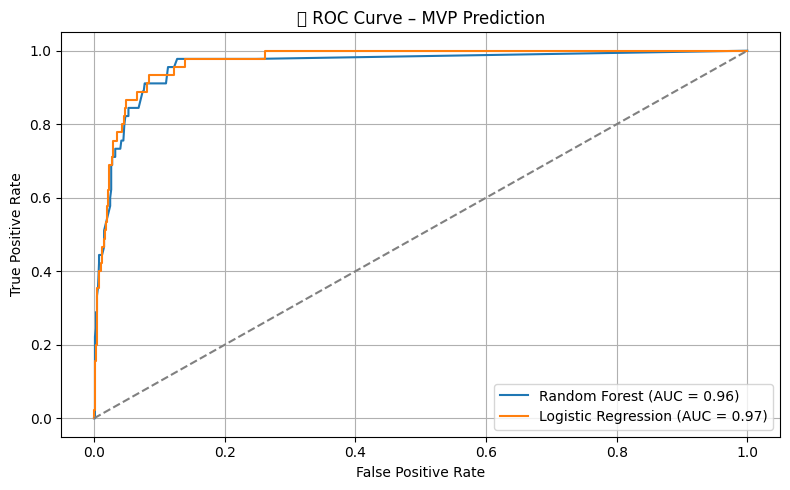

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# 🔹 1. Daten einlesen
df = pd.read_csv("nba_all_seasons.csv")

# 🔹 2. Feature Engineering
df["Total_Contribution"] = df["PPG"] + df["RPG"] + df["APG"]
df["Top_Team"] = df["Winrate"].apply(lambda x: 1 if x >= 0.6 else 0)
df["High_Scorer"] = df["PPG"].apply(lambda x: 1 if x >= 25 else 0)
df["Playmaker"] = df["APG"].apply(lambda x: 1 if x >= 5 else 0)
df["Rebounder"] = df["RPG"].apply(lambda x: 1 if x >= 8 else 0)

# 🔹 3. Features & Ziel
X = df[["PPG", "RPG", "APG", "Winrate", "Total_Contribution", "Top_Team", "High_Scorer", "Playmaker", "Rebounder"]]
y = df["MVP"]

# 🔹 4. Fehlende Werte entfernen
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy.drop(columns=["MVP"])
y = Xy["MVP"]

# 🔹 5. Skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 🔹 6. Train/Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🔹 7. Modelle trainieren
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
lr_model = LogisticRegression(class_weight="balanced", max_iter=1000)

rf_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# 🔹 8. Vorhersagen & Wahrscheinlichkeiten
y_pred_rf = rf_model.predict(X_test)
y_pred_lr = lr_model.predict(X_test)

y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
y_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# 🔹 9. Evaluation (F1 etc.)
print("📊 Random Forest:")
print(classification_report(y_test, y_pred_rf))

print("📊 Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

# 🔹 10. ROC Curve Plot
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 5))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("🏀 ROC Curve – MVP Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# 6. Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 8. Modelltraining
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Vorhersagen auf Testdaten
y_pred = model.predict(X_test)

# Bewertung
print("📊 Klassifikationsreport (Testdaten):")
print(classification_report(y_test, y_pred))

print("📉 Konfusionsmatrix:")
print(confusion_matrix(y_test, y_pred))


📊 Klassifikationsreport (Testdaten):
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       712
           1       0.69      0.52      0.60        48

    accuracy                           0.96       760
   macro avg       0.83      0.75      0.79       760
weighted avg       0.95      0.96      0.95       760

📉 Konfusionsmatrix:
[[701  11]
 [ 23  25]]


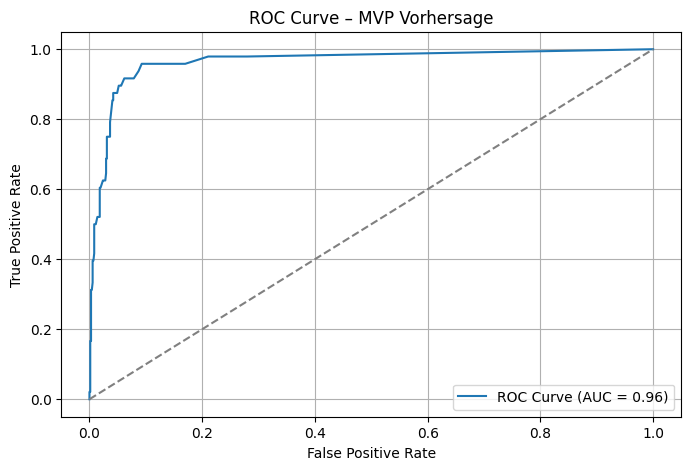

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – MVP Vorhersage")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
import joblib

# Modell und Scaler speichern
joblib.dump(model, "mvp_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [ ]:
import pandas as pd
import joblib

# -----------------------------
# 🔹 1. Rohdaten laden (Spielerstatistiken)
# -----------------------------
df = pd.read_csv("nba_24_25_ppg.csv", sep=";")  # Deine Rohdatei (mit PTS, TRB, AST, G, Team etc.)




# -----------------------------
# 🔹 4. Team-Rankings laden & bereinigen
# -----------------------------
team_df = pd.read_csv("nba_24_25_teamranking.csv", sep=";")
team_df = team_df.rename(columns={"W/L%": "Winrate"})
team_df = team_df[["Team", "Winrate"]]
team_df["Team"] = team_df["Team"].str.strip()
team_df["Winrate"] = pd.to_numeric(team_df["Winrate"], errors="coerce")

# -----------------------------
# 🔹 5. Merge Spieler + Teamdaten
# -----------------------------
merged_df = pd.merge(df_clean, team_df, on="Team", how="left")

# -----------------------------
# 🔹 6. Zusätzliche Features
# -----------------------------
merged_df["Total_Contribution"] = merged_df["PPG"] + merged_df["RPG"] + merged_df["APG"]
merged_df["Top_Team"] = merged_df["Winrate"].apply(lambda x: 1 if x >= 0.6 else 0)
merged_df["High_Scorer"] = merged_df["PPG"].apply(lambda x: 1 if x >= 25 else 0)
merged_df["Playmaker"] = merged_df["APG"].apply(lambda x: 1 if x >= 5 else 0)
merged_df["Rebounder"] = merged_df["RPG"].apply(lambda x: 1 if x >= 8 else 0)

# -----------------------------
# 🔹 7. Modell & Scaler laden
# -----------------------------
model = joblib.load("mvp_model.pkl")
scaler = joblib.load("scaler.pkl")

# -----------------------------
# 🔹 8. Features vorbereiten & skalieren
# -----------------------------
X = merged_df[["PPG", "RPG", "APG", "Winrate", "Total_Contribution", "Top_Team", "High_Scorer", "Playmaker", "Rebounder"]]
X_scaled = scaler.transform(X)

# -----------------------------
# 🔹 9. Vorhersagen machen
# -----------------------------
merged_df["MVP_Probability"] = model.predict_proba(X_scaled)[:, 1]
merged_df["MVP_Prediction"] = model.predict(X_scaled)

# -----------------------------
# 🔹 10. Ergebnisse anzeigen & speichern
# -----------------------------
top10 = merged_df[["Player", "Team", "PPG", "MVP_Probability"]].sort_values(by="MVP_Probability", ascending=False).head(10)

print("🏆 Top 10 MVP-Kandidaten (24/25):")
print(top10)

merged_df.to_csv("nba_24_25_with_predictions.csv", index=False)
print("✅ Fertig: Ergebnis gespeichert als nba_24_25_with_predictions.csv")


NameError: name 'df_clean' is not defined